# Clustering based on BYTES, PACKETS, DURATION

## Preparing a dataset

Load the dataset.

In [1]:
from cesnet_datazoo.datasets import CESNET_QUIC22, CESNET_TLS22

dataset = CESNET_QUIC22(data_root="data/CESNET_QUIC22/", size="XS", silent=True)

Prepare the dataset with config and check its columns.

In [ ]:
from cesnet_datazoo.config import DatasetConfig

dataset_config = DatasetConfig(
    dataset=dataset,
    train_period_name="W-2022-44",
    train_size=100_000,
    use_packet_histograms=True,
    # return_other_fields=True,
)
dataset.set_dataset_config_and_initialize(dataset_config)

data_df = dataset.get_train_df()
data_df.columns

Add imports.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Prepare the dataset dataframe.
Convert APP column to APP_NAME.

In [4]:
data_df["APP_NAME"] = data_df["APP"].apply(lambda x: dataset._tables_app_enum.get(x, "Unknown"))

data_df["APP_NAME"].value_counts()

APP_NAME
bongacams                6830
cloudflare-cdnjs         6355
alza-identity            6323
flightradar24            6110
playradio                5551
                         ... 
google-authentication       9
instagram                   9
ebay-kleinanzeigen          9
google-autofill             8
uber                        7
Name: count, Length: 101, dtype: int64

## Feature extraction

Create new features.

In [5]:
data_df["BYTES_PER_PACKET"] = data_df["BYTES"] / data_df["PACKETS"]
data_df["BYTES_PER_PACKET_REV"] = data_df["BYTES_REV"] / data_df["PACKETS_REV"]

Get only the columns that are needed for clustering.

In [6]:
features_to_extract = ["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION", "PPI_LEN", "PPI_ROUNDTRIPS", "PPI_DURATION",
                       "BYTES_PER_PACKET", "BYTES_PER_PACKET_REV"]

features_array = data_df[features_to_extract].to_numpy()
app_array = data_df[["APP"]].to_numpy().reshape(-1)

## Preprocessing

Standardize the features.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

preprocessed_array = preprocessing_pipeline.fit_transform(features_array)

## KMeans

### Clustering

Cluster the data using KMeans.

In [8]:
from sklearn.cluster import KMeans

NUMBER_OF_MULTIPLIERS = 10

number_of_clusters = np.unique(app_array).shape[0]

kmeans_partitions = []

for cluster_multiplier in range(1, NUMBER_OF_MULTIPLIERS+1):
    kmeans = KMeans(n_clusters=number_of_clusters * cluster_multiplier, random_state=42)
    kmeans.fit(preprocessed_array)
    kmeans_partitions.append(kmeans.labels_)

### Evaluation

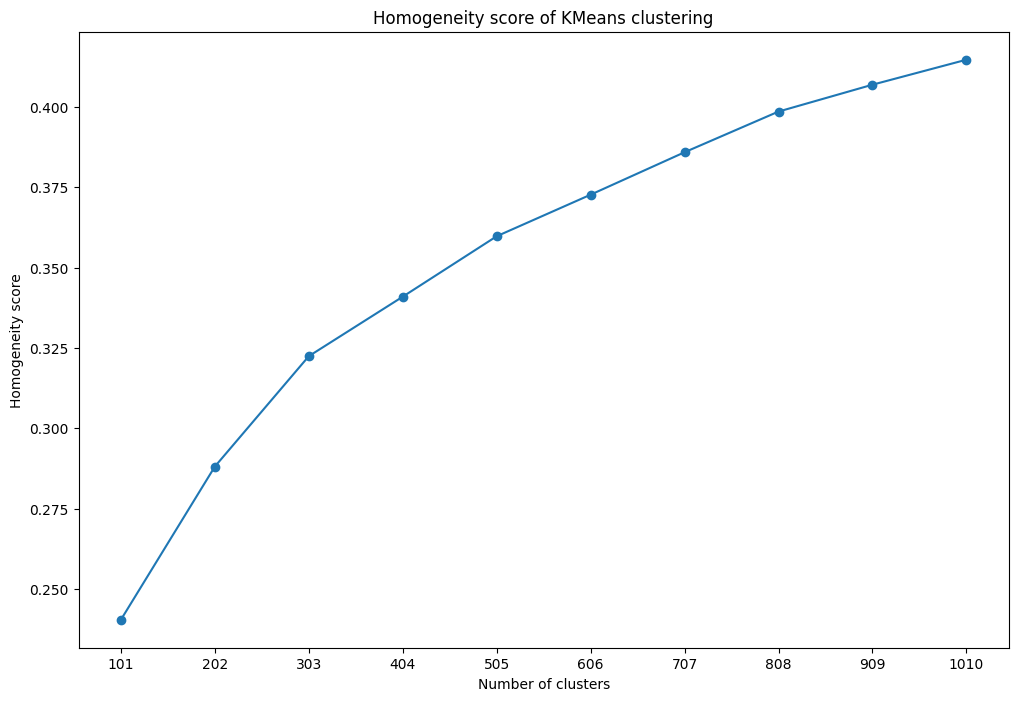

In [9]:
from sklearn.metrics.cluster import homogeneity_score

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters), [homogeneity_score(app_array, kmeans) for kmeans in kmeans_partitions], marker='o')
ax.set_title("Homogeneity score of KMeans clustering")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Homogeneity score")
ax.set_xticks(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters))
plt.show()
# fig.savefig("kmeans_firsttry_homogeneity_score.png", bbox_inches='tight')

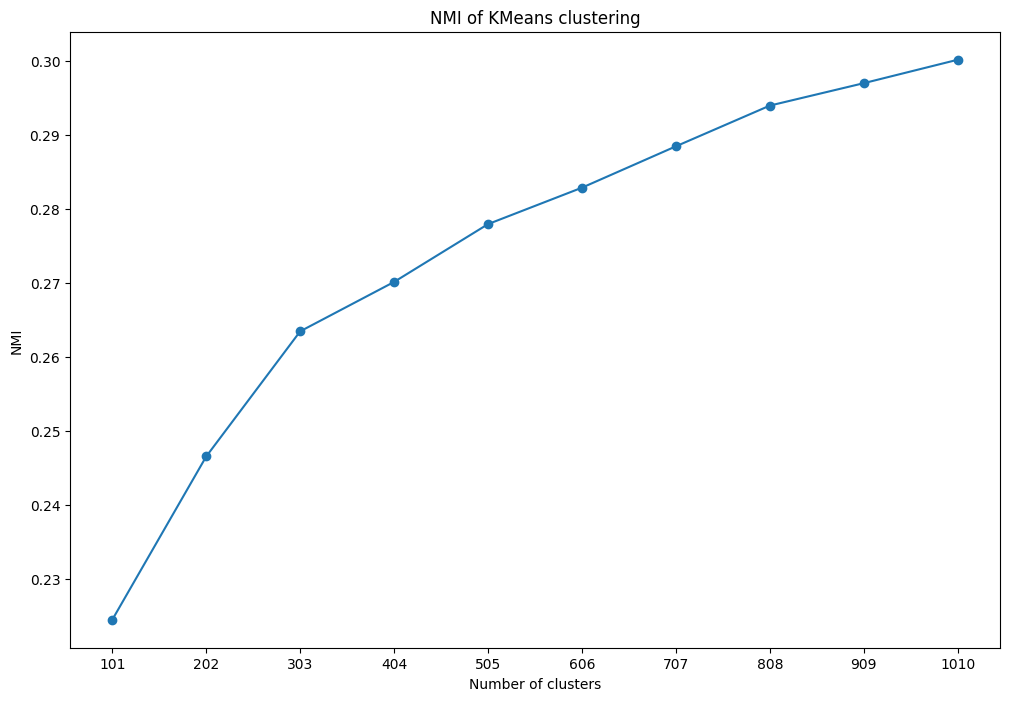

In [10]:
from sklearn.metrics.cluster import normalized_mutual_info_score

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters), [normalized_mutual_info_score(app_array, kmeans) for kmeans in kmeans_partitions], marker='o')
ax.set_title("NMI of KMeans clustering")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("NMI")
ax.set_xticks(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters))
plt.show()
fig.savefig("kmeans_firsttry_nmi.png", bbox_inches='tight')

In [11]:
from sklearn.metrics.cluster import pair_confusion_matrix

pair_confusion = pair_confusion_matrix(app_array, kmeans_partitions[0])
# divide everything by the number of packets
pair_confusion = pair_confusion / (np.sum(pair_confusion) - pair_confusion[0, 0])

pair_confusion

array([[16.5684424 ,  0.32850328],
       [ 0.62037146,  0.05112525]])

In [12]:
from sklearn.metrics.cluster import contingency_matrix

matrix = contingency_matrix(app_array, kmeans_partitions[0])

top_5_indices = np.argpartition(matrix.flatten(), -5)[-5:]

top_5_indices = top_5_indices[np.argsort(-matrix.flatten()[top_5_indices])]

top_5_positions = [np.unravel_index(idx, matrix.shape) for idx in top_5_indices]

top_5_values = matrix.flatten()[top_5_indices]

print("Top 5 values:", top_5_values)
print("Positions of top 5 values:", top_5_positions)

top_5_positions = list(map(lambda x: (dataset._tables_app_enum.get(x[0], "Unknown"), dataset._tables_app_enum.get(x[1], "Unknown")), top_5_positions))

top_5_positions

Top 5 values: [2197 2181 1278 1194 1050]
Positions of top 5 values: [(59, 48), (50, 8), (62, 27), (49, 27), (75, 11)]


[('cloudflare-cdnjs', 'unitygames'),
 ('easybrain', 'google-fonts'),
 ('bongacams', 'facebook-graph'),
 ('blitz-gg', 'facebook-graph'),
 ('pocasidata-cz', 'google-photos')]

In [13]:
from sklearn.metrics import confusion_matrix
import itertools

def top_confused_label_pairs(y_true, y_pred, top_n=5):
    """
    Returns the top N confused label pairs (true vs predicted) from the confusion matrix.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels (e.g., from clustering).
        top_n (int): Number of top confused pairs to return.

    Returns:
        List of tuples: [((true_label, predicted_label), count), ...]
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    num_classes = conf_matrix.shape[0]

    confused_pairs = []
    for i, j in itertools.product(range(num_classes), repeat=2):
        if i != j:
            confused_pairs.append(((i, j), conf_matrix[i, j]))

    top_confused = sorted(confused_pairs, key=lambda x: x[1], reverse=True)[:top_n]
    return top_confused

top_confused = top_confused_label_pairs(app_array, kmeans_partitions[0], top_n=5)

top_confused = list(map(lambda x: ((dataset._tables_app_enum.get(x[0][0], "Unknown"), dataset._tables_app_enum.get(x[0][1], "Unknown")), x[1]), top_confused))

top_confused

[(('cloudflare-cdnjs', 'unitygames'), 2197),
 (('easybrain', 'google-fonts'), 2181),
 (('bongacams', 'facebook-graph'), 1278),
 (('blitz-gg', 'facebook-graph'), 1194),
 (('pocasidata-cz', 'google-photos'), 1050)]

In [14]:
dataset.class_info.categories_mapping

{'4chan': 'Blogs & News',
 'adavoid': 'Other services and APIs',
 'alza-identity': 'Authentication services',
 'alza-webapi': 'Other services and APIs',
 'alza-www': 'E-commerce',
 'apple-privaterelay': 'Other services and APIs',
 'bitdefender-nimbus': 'Antivirus',
 'bitly': 'Other services and APIs',
 'blitz-gg': 'Games',
 'blogger': 'Blogs & News',
 'cedexis': 'Other services and APIs',
 'chess-com': 'Games',
 'chrome-remotedesktop': 'Other services and APIs',
 'cloudflare-cdnjs': 'Streaming media',
 'connectad': 'Advertising',
 'csgo-market': 'Games',
 'dcard': 'Social',
 'discord': 'Instant messaging',
 'dm-de': 'E-commerce',
 'dns-doh': 'Other services and APIs',
 'doi-org': 'Other services and APIs',
 'drmax': 'E-commerce',
 'easybrain': 'Games',
 'ebay-kleinanzeigen': 'E-commerce',
 'endnote-click': 'Other services and APIs',
 'etoro': 'Information systems',
 'facebook-connect': 'Authentication services',
 'facebook-gamesgraph': 'Other services and APIs',
 'facebook-graph': 'Oth

## HDBSCAN

In [15]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN().fit(preprocessed_array)

In [16]:
np.unique(hdbscan.labels_).shape

(3940,)

In [17]:
from sklearn.metrics.cluster import homogeneity_score

homogeneity_score(app_array, hdbscan.labels_)

0.37603684727034925

In [18]:
from sklearn.metrics.cluster import pair_confusion_matrix

pair_confusion = pair_confusion_matrix(app_array, hdbscan.labels_)
# divide everything by the number of packets
pair_confusion = pair_confusion / (np.sum(pair_confusion) - pair_confusion[0, 0])

pair_confusion

array([[2.61029814, 0.86200807],
       [0.10304605, 0.03494588]])

In [19]:
from sklearn.metrics.cluster import contingency_matrix

matrix = contingency_matrix(app_array, hdbscan.labels_)

top_5_indices = np.argpartition(matrix.flatten(), -5)[-5:]

top_5_indices = top_5_indices[np.argsort(-matrix.flatten()[top_5_indices])]

top_5_positions = [np.unravel_index(idx, matrix.shape) for idx in top_5_indices]

top_5_values = matrix.flatten()[top_5_indices]

print("Top 5 values:", top_5_values)
print("Positions of top 5 values:", top_5_positions)

top_5_positions = list(map(lambda x: (dataset._tables_app_enum.get(x[0], "Unknown"), dataset._tables_app_enum.get(x[1], "Unknown")), top_5_positions))

top_5_positions

Top 5 values: [3654 3606 3208 2731 2552]
Positions of top 5 values: [(66, 0), (41, 0), (62, 0), (29, 0), (55, 0)]


[('flightradar24', 'default-background'),
 ('alza-identity', 'default-background'),
 ('bongacams', 'default-background'),
 ('facebook-media', 'default-background'),
 ('playradio', 'default-background')]

In [20]:
data_df[features_to_extract][data_df["APP_NAME"] == "default-background"].describe(percentiles=[0.05, 0.5, 0.75, 0.90, 0.95]).round(2)

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,PPI_LEN,PPI_ROUNDTRIPS,PPI_DURATION,BYTES_PER_PACKET,BYTES_PER_PACKET_REV
count,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00
mean,21.05,37.00,5595.26,35991.58,6.87,24.16,4.47,1.59,321.45,748.27
std,19.83,41.18,5861.55,45534.57,14.96,6.71,1.31,3.58,189.28,297.74
min,5.00,7.00,1758.00,2820.00,0.02,14.00,2.00,0.02,113.51,323.00
5%,5.90,7.00,1962.30,2820.00,0.02,14.90,2.90,0.02,129.51,343.00
50%,12.00,18.00,4070.00,14808.00,0.24,30.00,4.00,0.20,316.62,815.37
75%,27.50,52.00,5066.00,55519.00,7.80,30.00,6.00,0.24,383.69,1044.75
90%,39.20,77.80,9822.80,82599.60,15.75,30.00,6.00,7.40,454.03,1073.00
95%,51.80,131.00,11850.60,134874.30,31.59,30.00,6.00,8.80,614.86,1078.45
max,86.00,149.00,27912.00,159681.00,60.93,30.00,6.00,12.52,915.09,1080.31


## DBSCAN

### Preparation

Let's start with elbow method to find the optimal number of clusters.

In [21]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

# If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).
neighbors = NearestNeighbors(n_neighbors=20).fit(preprocessed_array)
distances, _ = neighbors.kneighbors(preprocessed_array)

(99500.0, 100000.0, 0.0, 5.0)

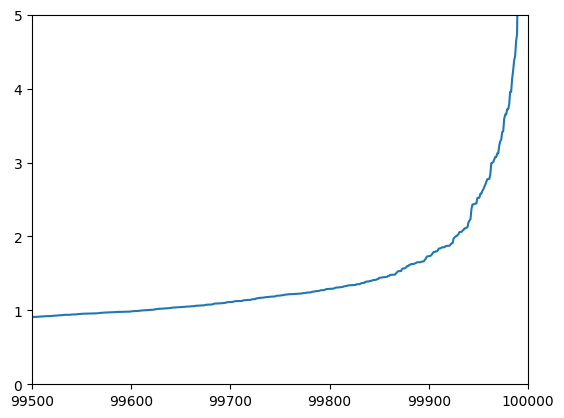

In [22]:
distances = np.sort(distances, axis=0)
plt.plot(distances[:,1])
plt.axis([99500, 100000, 0, 5])

### Clustering

DBSCAN clustering.

In [23]:
from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(eps=2.5, min_samples=20).fit(preprocessed_array)

### Evaluation

In [24]:
# homogeneity_score(app_array, dbscan.labels_)

## Visualization

### Scatter plot using t-SNE

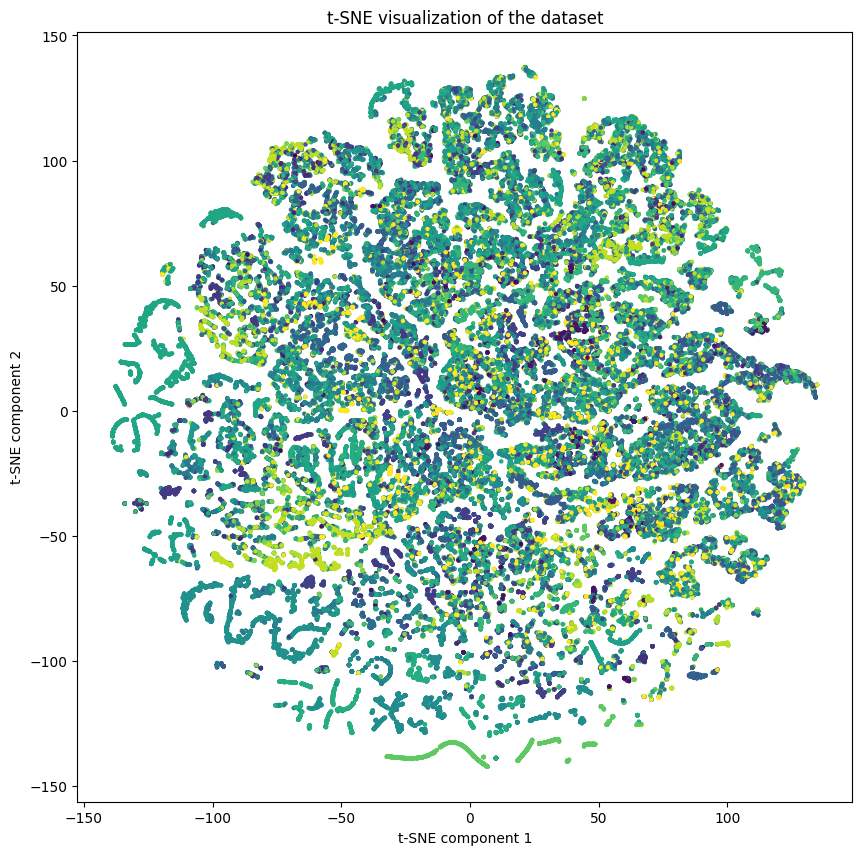

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_array = tsne.fit_transform(preprocessed_array)

fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(tsne_array[:, 0], tsne_array[:, 1], c=app_array, cmap='viridis', s=5)
ax.set_title("t-SNE visualization of the dataset")
ax.set_xlabel("t-SNE component 1")
ax.set_ylabel("t-SNE component 2")
plt.show()
fig.savefig("tsne_firsttry.png", bbox_inches='tight')

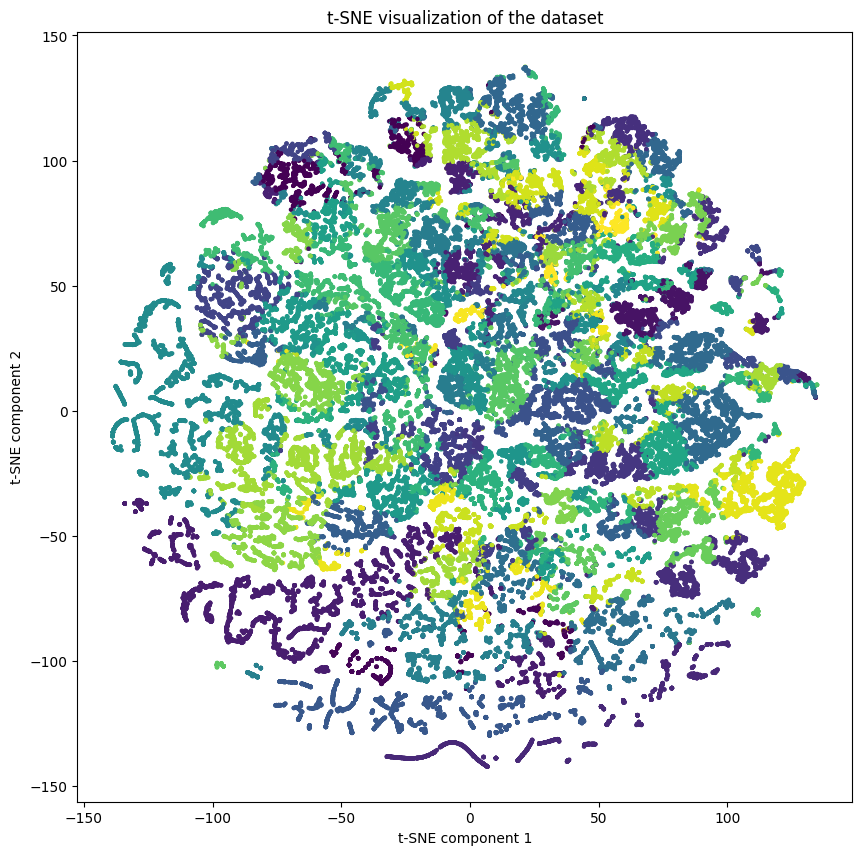

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(tsne_array[:, 0], tsne_array[:, 1], c=kmeans_partitions[0], cmap='viridis', s=5)
ax.set_title("t-SNE visualization of the dataset")
ax.set_xlabel("t-SNE component 1")
ax.set_ylabel("t-SNE component 2")
plt.show()
fig.savefig("tsne_kmeans_firsttry.png", bbox_inches='tight')